## Task 1 Variational Autoencoder

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms as T
from tqdm import tqdm
import argparse
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class VAE(nn.Module):

    def __init__(self, num_channels=1, num_classes=10, latent_dim=2, embed_dim=16):
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim
        self.embedding = nn.Embedding(num_embeddings=num_classes, embedding_dim=embed_dim)

        self.encoder = nn.ModuleList([
            nn.Conv2d(in_channels=num_channels, out_channels=8, kernel_size=3, stride=2, padding=1),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
        ])

        self.decoder = nn.ModuleList([
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3),
            nn.Conv2d(in_channels=8, out_channels=num_channels, kernel_size=3, padding=1),
        ])
        self.fc_latent = nn.Linear(in_features=latent_dim + embed_dim, out_features=512)

        self.fc_mean = nn.Linear(in_features=512 + embed_dim, out_features=latent_dim)
        self.fc_var = nn.Linear(in_features=512 + embed_dim, out_features=latent_dim)
        self.leaky_relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, y):
        """
        Args:
            x (tensor): Image(s) of shape [B, C, H, W].
            y (tensor): Class label(s) of shape [B,].

        Returns:
            x_recon (tensor): Reconstructed image(s) of shape [B, C, H, W].
            mean (tensor): Mean of shape [B, latent_dim]. 
            log_var (tensor): Log variance of shape [B, latent_dim].
        """
        mean, log_var = self.encode(x, y)
        # Reparameterization Trick
        eps = torch.randn(log_var.shape, device=log_var.device)
        z = mean + torch.exp(log_var * 0.5) * eps
        x_recon = self.decode(z, y)
        return x_recon, mean, log_var

    def encode(self, x, y):
        """
        Args:
            x (tensor): Image(s) of shape [B, C, H, W].
            y (tensor): Class label(s) of shape [B,].

        Returns:
            mean (tensor): Mean of shape [B, latent_dim]. 
            log_var (tensor): Log variance of shape [B, latent_dim].
        """
        for layer in self.encoder:
            x = layer(x)
            x = self.leaky_relu(x)
        x = torch.reshape(x, (x.shape[0], -1))
        class_embed = self.embedding(y)
        # Concat class information
        mean = self.fc_mean(torch.cat((x, class_embed), dim=1))
        log_var = self.fc_var(torch.cat((x, class_embed), dim=1))
        return mean, log_var

    def decode(self, z, y):
        """
        Args:
            z (tensor): Latent variable(s) of shape [B, latent_dim].
            y (tensor): Class label(s) of shape [B,].

        Returns:
            x (tensor): Reconstructed image(s) of shape [B, C, H, W].
        """
        class_embed = self.embedding(y)
        # Concat class information
        x = self.fc_latent(torch.cat((z, class_embed), dim=1))
        x = torch.reshape(x, (-1, 32, 4, 4))
        for layer in self.decoder:
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
            x = self.leaky_relu(x)
            x = layer(x)
        x = self.sigmoid(x)
        return x

    def sample(self, y, device):
        """
        Args:
            y (int): Class label.
            device (torch.device): Which device to use (cuda or cpu).

        Returns:
            (tensor): Image of shape [1, C, H, W].
        """
        z = torch.randn((1, self.latent_dim), device=device)
        return self.decode(z, torch.tensor([y], device=device))

    def sample_latent(self, x, y):
        """
        Args:
            x (tensor): Image(s) of shape [B, C, H, W].
            y (tensor): Class label(s) of shape [B,].

        Returns:
            z (tensor): Latent variable(s) of shape [B, latent_dim].
        """
        mean, log_var = self.encode(x, y)
        # Reparameterization Trick
        eps = torch.randn(log_var.shape, device=log_var.device)
        z = mean + torch.exp(log_var * 0.5) * eps
        return z

100%|██████████| 235/235 [00:02<00:00, 92.78it/s] 


Epoch 0, Loss: 0.050931


100%|██████████| 235/235 [00:01<00:00, 132.50it/s]


Epoch 1, Loss: 0.032209


100%|██████████| 235/235 [00:01<00:00, 134.92it/s]


Epoch 2, Loss: 0.025725


100%|██████████| 235/235 [00:01<00:00, 124.44it/s]


Epoch 3, Loss: 0.023081


100%|██████████| 235/235 [00:01<00:00, 131.00it/s]


Epoch 4, Loss: 0.020926


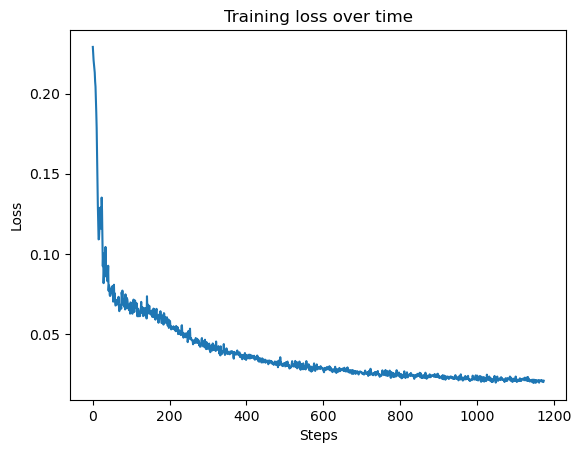

In [3]:
import os
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms as T
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

class Args:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

def train(kwargs):
    # initialize data
    transform = T.Compose([
        T.ToTensor(),
    ])
    data_train = datasets.MNIST('data', train=True, download=True, transform=transform)

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=kwargs.batch_size, num_workers=8)
    
    # initialize model
    device = torch.device('cuda:7') if torch.cuda.is_available() else torch.device('cpu')
    model = VAE(num_channels=1, num_classes=10, latent_dim=kwargs.latent_dim).to(device)

    # initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs.learning_rate)
    
    steps = []
    losses = []
    step = 0

    for epoch in range(kwargs.num_epochs):
        for (x, y) in tqdm(train_loader):
            x, y = x.to(device), y.to(device)
            x_recon, mean, log_var = model(x, y)

            mse = torch.mean(torch.square(x - x_recon))
            kl_div = 0.5 * torch.sum(torch.exp(log_var) + torch.square(mean) - log_var - 1, dim=1)
            loss = kwargs.mse_weight * mse + kwargs.kl_weight * torch.mean(kl_div)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            steps.append(step)
            step += 1

        print(f'Epoch {epoch}, Loss: {loss:.5}')

    torch.save(model.state_dict(), kwargs.ckpt_path)

    sns.lineplot(x=steps, y=losses)
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training loss over time')
    plt.savefig('training_curve.jpg')

def sample(kwargs):
    os.makedirs('samples', exist_ok=True)
    device = torch.device('cuda:7') if torch.cuda.is_available() else torch.device('cpu')
    model = VAE(num_channels=1, num_classes=10, latent_dim=kwargs.latent_dim).to(device)
    state_dict = torch.load(kwargs.ckpt_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()

    for i in range(10):
        x = model.sample(i, device)
        x = x.squeeze(dim=0).squeeze(dim=0)
        x = x.detach().cpu().numpy()
        x = np.uint8(x * 255)
        img = Image.fromarray(x)
        img.save(f'samples/sample_{i}.jpg')

# Define the kwargs dictionary
kwargs_dict = {
    'num_epochs': 5,
    'batch_size': 256,
    'latent_dim': 64,
    'learning_rate': 0.001,
    'mse_weight': 1.0,
    'kl_weight': 0.0001,
    'ckpt_path': 'vae.pth',
    'mode': 'train'  # Change this value to 'sample' or 'vis' as needed
}

# Convert the dictionary to an Args object
kwargs = Args(**kwargs_dict)

# Use the mode to determine which function to call
if kwargs.mode == 'train':
    train(kwargs)
elif kwargs.mode == 'sample':
    sample(kwargs)
elif kwargs.mode == 'vis':
    visualize_latent_space(kwargs)


# Task 2 Visualize Latents

In [4]:
def visualize_latent_space(args):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = VAE(num_channels=1, num_classes=10, latent_dim=args.latent_dim).to(device)
    state_dict = torch.load(args.ckpt_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()

    transform=T.Compose([
        T.ToTensor(),
    ])
    data_test = datasets.MNIST('data', train=False, transform=transform)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=args.batch_size)
    
    latents = []
    labels = []

    for (x, y) in tqdm(test_loader):
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            z = model.sample_latent(x, y)
        latents.append(z.detach().cpu().numpy())
        labels.append(y.detach().cpu().numpy())

    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    sns.scatterplot(x=latents[:, 0], y=latents[:, 1], hue=labels, palette='tab10')
    plt.title('Latent variables')
    plt.savefig(f'latent_vis_{args.ckpt_path[:args.ckpt_path.rfind(".")]}.jpg')

100%|██████████| 40/40 [00:00<00:00, 51.21it/s]


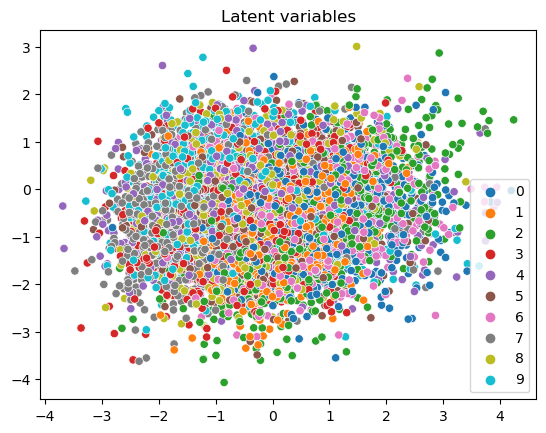

In [5]:
# Define the kwargs dictionary
kwargs_dict = {
    'num_epochs': 5,
    'batch_size': 256,
    'latent_dim': 64,
    'learning_rate': 0.001,
    'mse_weight': 1.0,
    'kl_weight': 0.0001,
    'ckpt_path': 'vae.pth',
    'mode': 'vis'  # Change this value to 'sample' or 'vis' as needed
}

# Convert the dictionary to an Args object
kwargs = Args(**kwargs_dict)

# Use the mode to determine which function to call
if kwargs.mode == 'train':
    train(kwargs)
elif kwargs.mode == 'sample':
    sample(kwargs)
elif kwargs.mode == 'vis':
    visualize_latent_space(kwargs)

# Task 3 Anomaly Detection using VAE

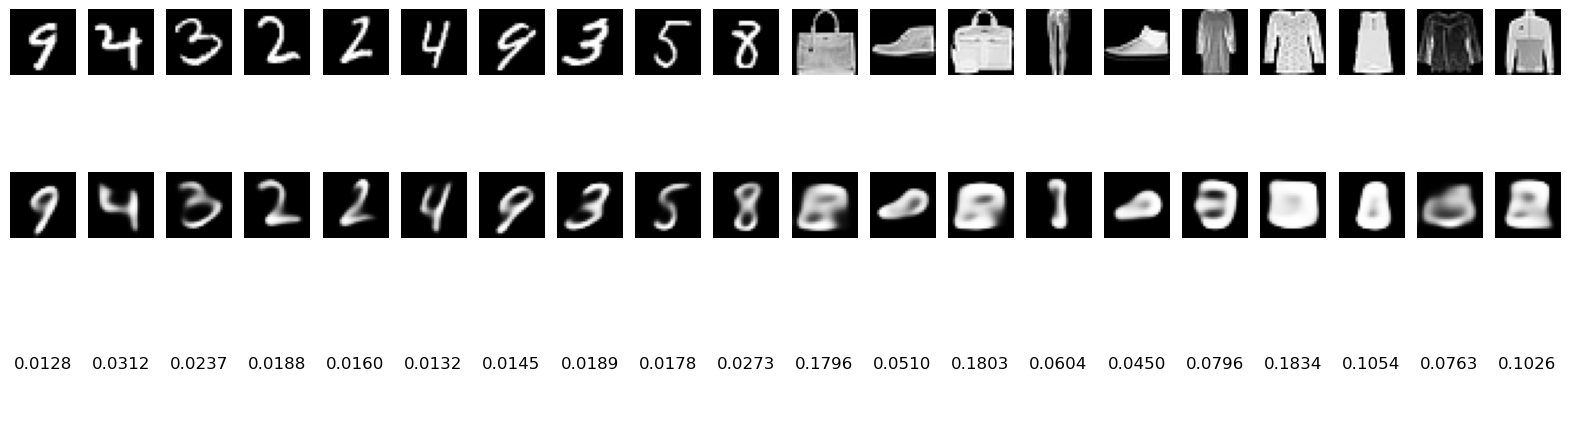

In [6]:
import random
from torch.utils.data import DataLoader, Subset, ConcatDataset

def anomaly_detection(kwargs):
    transform = T.Compose([
        T.ToTensor(),
    ])
    
    # Load MNIST and Fashion-MNIST datasets
    mnist_data = datasets.MNIST('data', train=False, download=True, transform=transform)
    fashion_mnist_data = datasets.FashionMNIST('data', train=False, download=True, transform=transform)
    
    # Create a mixed dataset with 50% MNIST and 50% Fashion-MNIST
    mnist_indices = list(range(len(mnist_data)))
    fashion_mnist_indices = list(range(len(fashion_mnist_data)))
    
    random.shuffle(mnist_indices)
    random.shuffle(fashion_mnist_indices)
    
    half_size = min(len(mnist_indices), len(fashion_mnist_indices)) // 2
    mixed_indices = mnist_indices[:half_size] + fashion_mnist_indices[:half_size]
    mixed_labels = [0] * half_size + [1] * half_size  # 0 for MNIST, 1 for Fashion-MNIST
    
    # Limit to N images
    N = kwargs.num_images
    mixed_indices = mixed_indices[:N]
    mixed_labels = mixed_labels[:N]
    
    # Create a mixed dataset
    mnist_subset = Subset(mnist_data, mnist_indices[:N//2])
    fashion_mnist_subset = Subset(fashion_mnist_data, fashion_mnist_indices[:N//2])
    mixed_data = ConcatDataset([mnist_subset, fashion_mnist_subset])
    
    mixed_loader = DataLoader(mixed_data, batch_size=kwargs.batch_size, shuffle=False)
    
    # Load the trained VAE model
    device = torch.device('cuda:7') if torch.cuda.is_available() else torch.device('cpu')
    model = VAE(num_channels=1, num_classes=10, latent_dim=kwargs.latent_dim).to(device)
    state_dict = torch.load(kwargs.ckpt_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    
    # Plot original and reconstructed images
    fig, axes = plt.subplots(3, N, figsize=(20, 6))
    
    idx = 0
    for x, y in mixed_loader:
        x, y = x.to(device), y.to(device)
        x_recon, _, _ = model(x, y)
        
        for j in range(x.size(0)):
            if idx >= N:
                break
            axes[0, idx].imshow(x[j].squeeze().cpu().numpy(), cmap='gray')
            axes[0, idx].axis('off')
            axes[1, idx].imshow(x_recon[j].squeeze().cpu().detach().numpy(), cmap='gray')
            axes[1, idx].axis('off')
            
            # Calculate reconstruction error
            recon_error = torch.mean((x[j] - x_recon[j]) ** 2).item()
            axes[2, idx].text(0.5, 0.5, f'{recon_error:.4f}', fontsize=12, ha='center')
            axes[2, idx].axis('off')
            
            idx += 1
    
    plt.show()

# Define the kwargs dictionary
kwargs_dict = {
    'num_epochs': 5,
    'batch_size': 16,
    'latent_dim': 64,
    'learning_rate': 0.001,
    'mse_weight': 1.0,
    'kl_weight': 0.0001,
    'ckpt_path': 'vae.pth',
    'mode': 'anomaly_detection',  # Change this value to 'train', 'sample', or 'anomaly_detection' as needed
    'num_images': 20  # Number of images to analyze
}

# Convert the dictionary to an Args object
kwargs = Args(**kwargs_dict)

# Use the mode to determine which function to call
if kwargs.mode == 'train':
    train(kwargs)
elif kwargs.mode == 'sample':
    sample(kwargs)
elif kwargs.mode == 'anomaly_detection':
    anomaly_detection(kwargs)
